# Logisitic Regression Modeling

In this notebook, we iterate through a logisitic regression baseline, trying different class imbalance remedy methods. We also grid search to try and optomize the baseline's hyperparameters.

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns; sns.set()
%matplotlib inline
import nltk
from sklearn.feature_extraction import text 
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
import pickle

In [37]:
X_lem = pickle.load(open('X_lem.pkl', 'rb'))
y_lem = pd.read_pickle('y_lem.pkl')

In [38]:
# setting up stop words
stop_words = set(stopwords.words('english'))

## Train-Test Split & Vectorize

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_lem, y_lem, test_size=0.20, random_state=15)


In [40]:
# Ensure stop_words is a list if it's custom
tfidf = TfidfVectorizer(stop_words=list(stop_words), ngram_range=(1, 2))  # Removed the comma

# Transform text
tfidf_data_train = tfidf.fit_transform(X_train)
tfidf_data_test = tfidf.transform(X_test)

### Class Imbalance in Training Set 

In [41]:
# creating single df for training set
X_train_df = pd.DataFrame(data=tfidf_data_train, index=None, columns=['tweet']) 
y_train_df = pd.DataFrame(data=y_train, index=None, columns=['label']) 
# joining them
training = pd.concat([X_train_df, y_train_df], axis=1)

In [42]:
training.head(2)

,tweet,label
0,"(0, 40114)\t0.1842260312784092\n (0, 7353)\...",0.0
1,"(0, 24418)\t0.2051240642608132\n (0, 88479)...",0.0


In [43]:
# separate minority and majority classes
hate = training[training.label==1]
not_hate = training[training.label==0]

In [44]:
hate.shape

(1151, 2)

In [45]:
not_hate.shape

(18675, 2)

We can see that this data has a huge **class imbalance**. After running a baseline, we can try oversampling the minority class (hate speech) with SMOTE and undersampling the majority class with Tomek Links.

## Baseline Logistic Regression


In [46]:
logreg_baseline = LogisticRegression(penalty='l2', class_weight='balanced', random_state=20)
# class_weight='balanced' actually didn't impact the score

In [47]:
%%time
logreg_baseline.fit(tfidf_data_train, y_train)
logreg_test_preds = logreg_baseline.predict(tfidf_data_test)

CPU times: total: 1.55 s
Wall time: 1.27 s


In [48]:
logreg_precision = precision_score(y_test, logreg_test_preds)
logreg_recall = recall_score(y_test, logreg_test_preds)
logreg_f1_score = f1_score(y_test, logreg_test_preds)
logreg_weighted_f1_score = f1_score(y_test, logreg_test_preds, average='weighted')

In [49]:
# printing evaluation metrics up to 4th decimal place
print('Testing Metrics for Logistic Regression Baseline with Lemmatization Features')
print('Precision: {:.4}'.format(logreg_precision))
print('Recall: {:.4}'.format(logreg_recall))
print('F1 Score: {:.4}'.format(logreg_f1_score))

Testing Metrics for Logistic Regression Baseline with Lemmatization Features
Precision: 0.295
Recall: 0.5699
F1 Score: 0.3888


In [50]:
# creating dictionary with all metrics
metric_dict = {}
metric_dict['Baseline Logisitic Regression'] = {'precision': logreg_precision, 'recall': logreg_recall, 'f1_score': logreg_f1_score, 'weighted_f1': logreg_weighted_f1_score}

(2.5, -0.5)

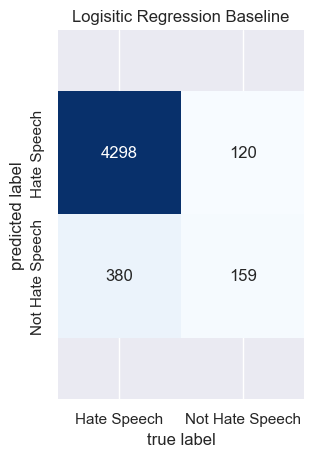

In [51]:
mat = confusion_matrix(y_test, logreg_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Hate Speech', 'Not Hate Speech'], yticklabels=['Hate Speech', 'Not Hate Speech'], cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Logisitic Regression Baseline')

# fixing matplotlib heatmap cutoff issue
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

## Baseline with SMOTE
Used to over-sample the minority class (hate speech).

In [52]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=35)
smote_X_train, smote_y_train = sm.fit_resample(tfidf_data_train, y_train)

In [53]:
smote_logreg = LogisticRegression(penalty='l2', random_state=35)

In [54]:
%%time
smote_logreg.fit(smote_X_train, smote_y_train)
smote_logreg_test_preds = smote_logreg.predict(tfidf_data_test)

CPU times: total: 1 s
Wall time: 740 ms


In [55]:
smote_precision = precision_score(y_test, smote_logreg_test_preds)
smote_recall = recall_score(y_test, smote_logreg_test_preds)
smote_f1_score = f1_score(y_test, smote_logreg_test_preds)
smote_weighted_f1_score = f1_score(y_test, smote_logreg_test_preds, average='weighted')

In [56]:
# printing evaluation metrics up to 4th decimal place
print('Testing Metrics for Oversampled Logistic Regression Baseline with Lemmatization Features')
print('Precision: {:.4}'.format(smote_precision))
print('Recall: {:.4}'.format(smote_recall))
print('F1 Score: {:.4}'.format(smote_f1_score))

Testing Metrics for Oversampled Logistic Regression Baseline with Lemmatization Features
Precision: 0.3194
Recall: 0.5197
F1 Score: 0.3956


In [57]:
metric_dict['Baseline Log Reg Oversampled with SMOTE'] = {'precision': smote_precision, 'recall': smote_recall, 'f1_score': smote_f1_score,  'weighted_f1': smote_weighted_f1_score}

## Baseline with Tomek Links
Used to under-sample the majority class (not hate speech).

In [58]:
from collections import Counter
from imblearn.under_sampling import TomekLinks # doctest: +NORMALIZE_WHITESPACE

tl = TomekLinks()
tomek_X_train, tomek_y_train = tl.fit_resample(tfidf_data_train, y_train)
print('Resampled dataset shape %s' % Counter(tomek_y_train))

Resampled dataset shape Counter({0: 18627, 1: 1151})


It only removed 48 values from the majority class.

In [59]:
tomek_logreg = LogisticRegression(penalty='l2', random_state=55)

In [60]:
%%time
tomek_logreg.fit(tomek_X_train, tomek_y_train)
tomek_logreg_test_preds = tomek_logreg.predict(tfidf_data_test)

CPU times: total: 1.42 s
Wall time: 1.6 s


In [61]:
tomek_precision = precision_score(y_test, tomek_logreg_test_preds)
tomek_recall = recall_score(y_test, tomek_logreg_test_preds)
tomek_f1_score = f1_score(y_test, tomek_logreg_test_preds)

In [62]:
# printing evaluation metrics up to 4th decimal place
print('Testing Metrics for Undersampled Logistic Regression Baseline with Lemmatization Features')
print('Precision: {:.4}'.format(tomek_precision))
print('Recall: {:.4}'.format(tomek_recall))
print('F1 Score: {:.4}'.format(tomek_f1_score))

Testing Metrics for Undersampled Logistic Regression Baseline with Lemmatization Features
Precision: 0.6909
Recall: 0.1362
F1 Score: 0.2275


In [63]:
metric_dict['Baseline Log Reg Undersampled with Tomek Links'] = {'precision': tomek_precision, 'recall': tomek_recall, 'f1_score': tomek_f1_score}

### Metrics for All Baselines

In [64]:
pd.DataFrame.from_dict(metric_dict, orient='index')

,precision,recall,f1_score,weighted_f1
Baseline Logisitic Regression,0.294991,0.569892,0.388753,0.913721
Baseline Log Reg Oversampled with SMOTE,0.319383,0.519713,0.395634,0.920448
Baseline Log Reg Undersampled with Tomek Links,0.690909,0.136201,0.227545,NaN


Out of all of them, **the baseline oversampled with SMOTE** performed the best. So let's run grid search on that one to find the optimal parameters.

It's important to note that this model produces the same score as a baseline SVM.